In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from scipy.special import expit

from ipywidgets import interact, FloatSlider, IntSlider


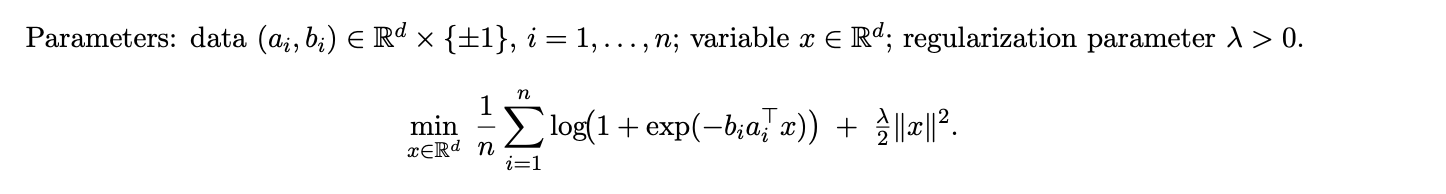

In [2]:
A, b = make_classification(n_samples=500, n_features=2, n_informative=2, n_redundant=0, n_clusters_per_class=1, random_state=42)
b = 2 * b - 1
A_bias = np.c_[np.ones(A.shape[0]), A]
n_samples, n_features = A_bias.shape

lambda_reg = 0.1
n_iterations = 1000

AtA = A_bias.T @ A_bias
max_eigenvalue = np.max(np.linalg.eigvals(AtA).real)
L = (1 / (4 * n_samples)) * max_eigenvalue
alpha = 1 / L

print(f"Lipschitz Constant L = {L:.4f}")
print(f"Step Size α = 1/L = {alpha:.4f}")

Lipschitz Constant L = 0.6394
Step Size α = 1/L = 1.5639


In [3]:
def objective_function(x, A, b, lam):
    n = A.shape[0]
    logistic_loss = (1/n) * np.sum(np.log(1 + np.exp(-b * (A @ x))))
    l2_reg = (lam / 2) * np.linalg.norm(x)**2
    return logistic_loss + l2_reg

In [4]:
def gradient_f(x, A, b):
    n = A.shape[0]
    sigmoids = expit(-b * (A @ x))
    grad = (1/n) * (A.T @ (-b * sigmoids))
    return grad

def proximal_operator_g(y, alpha, lam):
    return y / (1 + alpha * lam)

In [5]:
def composite_gradient_descent(A, b, lam, alpha, iterations):
    x = np.zeros(A.shape[1])  # Start at x_0 = 0
    objective_history = []

    for k in range(iterations):
        obj_val = objective_function(x, A, b, lam)
        objective_history.append(obj_val)

        grad = gradient_f(x, A, b)
        y = x - alpha * grad

        x = proximal_operator_g(y, alpha, lam)

    return x, objective_history

In [6]:
cgd_x, history = composite_gradient_descent(A_bias, b, lambda_reg, alpha, n_iterations)

print(f"Final Objective Value: {history[-1]:.4f}")
print(f"Optimal parameters x: {cgd_x}")

Final Objective Value: 0.4446
Optimal parameters x: [-0.12778861  0.09035571  1.12646314]


In [7]:
def run_cgd_ui(alpha ,n_iterations):

    cgd_x, history = composite_gradient_descent(A_bias, b, lambda_reg, alpha, n_iterations)
    fig, ax = plt.subplots(figsize=(7, 6))
    ax.plot(
        np.arange(1, len(history) + 1),
        history,
        label=f"SGD (final={history[-1]:.4f})",
        linewidth=2
    )

    ax.set_xlabel("Iteration")
    ax.set_ylabel("Objective F(x)")
    ax.set_title("CGD Convergence")
    ax.grid(True, alpha=0.3)
    ax.legend()

    plt.show()

interact(
    run_cgd_ui,
    alpha=FloatSlider(value=0.1, min=1e-4, max=1.6, step=1e-4, readout_format=".4f", description="step α"),
    n_iterations=IntSlider(value=20, min=20, max=100, step=5, description="epochs"),
);


interactive(children=(FloatSlider(value=0.1, description='step α', max=1.6, min=0.0001, readout_format='.4f', …

In [8]:
def run_cgd_ui(alpha, n_iterations):
    cgd_x, history = composite_gradient_descent(
        A_bias, b, lambda_reg, alpha, n_iterations
    )
    history = np.asarray(history)
    k_all = np.arange(1, len(history) + 1)


    tail_cut = max(3, len(history) // 20)
    F_star = history[:-tail_cut].min()
    gap = np.maximum(history - F_star, 1e-16)
    k = np.arange(1, len(gap) + 1)

    fig, ax0 = plt.subplots( figsize=(10, 6))


    ax0.plot(k, gap, linewidth=2, label=f"CGD gap (final={gap[-1]:.2e})")
    ax0.set_xlabel("Iteration k")
    ax0.set_ylabel("Gap  F(x_k) - F*")
    ax0.set_title("CGD Convergence (semilog-y)")
    ax0.set_yscale("log")
    ax0.grid(True, which="both", alpha=0.3)

    plt.show()

interact(
    run_cgd_ui,
    alpha=FloatSlider(value=0.1, min=1e-4, max=1.6, step=1e-4,
                      readout_format=".4f", description="step α"),
    n_iterations=IntSlider(value=25, min=5, max=200, step=5,
                           description="epochs"),
);


interactive(children=(FloatSlider(value=0.1, description='step α', max=1.6, min=0.0001, readout_format='.4f', …


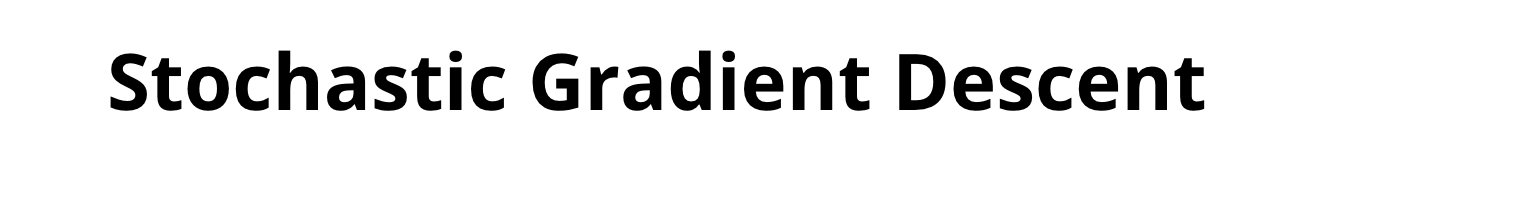

In [9]:
initial_learning_rate = 0.01
# decay = 0.001
n_epochs = 100

In [10]:
def stochastic_gradient(x, a_i, b_i, lam):
    grad_f_i = -b_i * a_i * expit(-b_i * (a_i @ x))
    grad_g = lam * x
    return grad_f_i + grad_g

In [11]:
def stochastic_gradient_descent(A, b, lam, alpha_0, epochs):
    x = np.zeros(A.shape[1])
    objective_history = []

    iteration_count = 0

    for epoch in range(epochs):
        obj_val = objective_function(x, A, b, lam)
        objective_history.append(obj_val)

        indices = np.random.permutation(n_samples)
        A_shuffled = A[indices]
        b_shuffled = b[indices]

        for i in range(n_samples):
            a_i = A_shuffled[i]
            b_i = b_shuffled[i]

            alpha_k = alpha_0 / (1 +  iteration_count)

            grad = stochastic_gradient(x, a_i, b_i, lam)

            x = x - alpha_k * grad

            iteration_count += 1

    return x, objective_history

In [12]:
sgd_x, sgd_history = stochastic_gradient_descent(A_bias, b, lambda_reg, initial_learning_rate, n_epochs)
print(f"Final Objective (SGD): {sgd_history[-1]:.4f}")
print(f"Final Weights (SGD): {sgd_x}")

Final Objective (SGD): 0.6636
Final Weights (SGD): [-0.00339777 -0.0031037   0.06046581]


In [13]:
diff_objval = sgd_history[-1] - history[-1]
print("difference between SGD and Composite",diff_objval)

difference between SGD and Composite 0.21898632072569174


In [14]:


# def run_sgd_ui(initial_learning_rate  ,n_epochs):
#     x_sgd, sgd_history = stochastic_gradient_descent(
#         A_bias, b, lambda_reg, initial_learning_rate, int(n_epochs)
#     )

#     fig, ax0 = plt.subplots(figsize=(14, 6))



#     ax0.plot(np.arange(1, len(sgd_history) + 1), sgd_history,
#              label=f"SGD (final={sgd_history[-1]:.4f})", linewidth=2)
#     ax0.set_xlabel("Epoch")
#     ax0.set_ylabel("Objective F(x)")
#     ax0.set_title("SGD Convergence")
#     ax0.grid(True, alpha=0.3)
#     ax0.legend()



#     # plt.tight_layout()
#     plt.show()

# interact(
#     run_sgd_ui,
#     initial_learning_rate=FloatSlider(value=0.0001, min=0.0001, max=0.01, step=1e-5, readout_format=".4f", description="lr₀"),
#     # decay=FloatSlider(value=0.0001, min=0.0001,  max=0.001, step=1e-7, readout_format=".5f", description="decay"),
#     n_epochs=IntSlider(value=50, min=5, max=200, step=5, description="epochs"),
# );


In [15]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider, IntSlider

# --- SGD that runs for an exact number of steps (iterations) ---
def sgd_by_steps(A, b, lam, alpha0, n_steps, schedule="1/k", c=1.0, t0=10, rng=None):

    if rng is None:
        rng = np.random.default_rng()

    m, d = A.shape
    x = np.zeros(d)
    history = []
    k = 0

    while k < n_steps:
        for i in rng.permutation(m):
            if k >= n_steps:
                break

            if schedule == "1/k":
                lr = (c * alpha0) / (t0 + 1 + k)
            elif schedule == "constant":
                lr = alpha0
            else:
                raise ValueError("schedule must be '1/k' or 'constant'")

            g = stochastic_gradient(x, A[i], b[i], lam)
            x = x - lr * g

            fval = objective_function(x, A, b, lam)
            history.append(fval)

            k += 1

    return x, np.asarray(history, dtype=float)

# --- UI/plot: mirrors your CGD plot but for SGD steps ---
def run_sgd_ui(alpha, n_iterations):
    x_sgd, history = sgd_by_steps(A_bias, b, lambda_reg, alpha, n_iterations,
                                  schedule="1/k", c=1.0, t0=10)

    fig, ax = plt.subplots(figsize=(7, 6))
    ax.plot(np.arange(1, len(history) + 1), history,
            label=f"SGD (final={history[-1]:.4f})", linewidth=2)
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Objective F(x)")
    ax.set_title("SGD Convergence")
    ax.set_yscale("log")
    ax.set_xscale("log")
    ax.grid(True, alpha=0.3)
    ax.legend()
    plt.show()

interact(
    run_sgd_ui,
    alpha=FloatSlider(value=0.1, min=1e-4, max=1.6, step=1e-4, readout_format=".4f", description="step α"),
    n_iterations=IntSlider(value=1000, min=50, max=50000, step=50, description="iterations"),
);


interactive(children=(FloatSlider(value=0.1, description='step α', max=1.6, min=0.0001, readout_format='.4f', …

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider, IntSlider

def sgd_by_steps(A, b, lam, alpha0, n_steps, schedule="1/k", c=1.0, t0=10, rng=None):
    if rng is None:
        rng = np.random.default_rng()

    m, d = A.shape
    x = np.zeros(d)
    history = []
    k = 0

    while k < n_steps:
        for i in rng.permutation(m):
            if k >= n_steps:
                break

            if schedule == "1/k":
                lr = (c * alpha0) / (t0 + 1 + k)
            elif schedule == "constant":
                lr = alpha0
            else:
                raise ValueError("schedule must be '1/k' or 'constant'")

            g = stochastic_gradient(x, A[i], b[i], lam)
            x = x - lr * g

            fval = objective_function(x, A, b, lam)
            history.append(fval)

            k += 1

    return x, np.asarray(history, dtype=float)

# --- UI/plot: includes F(x_k) and the gap F(x_k) - F* ---
def run_sgd_ui(alpha, n_iterations):
    x_sgd, history = sgd_by_steps(
        A_bias, b, lambda_reg, alpha, n_iterations,
        schedule="1/k", c=1.0, t0=10
    )

    k = np.arange(1, len(history) + 1)

    # --- robust F* from the tail, then gap ---
    tail = max(10, len(history) // 10)        # last 10% (at least 10 pts)
    F_star = np.median(history[-tail:])
    eps = 1e-12                                # keep >0 for log scales
    gaps = np.maximum(history - F_star, eps)

    fig, ax = plt.subplots(figsize=(7, 6))
    # ax.plot(k, history, label=f"F(x_k) (final={history[-1]:.4f})", linewidth=2)
    ax.plot(k, gaps, label=f"F(x_k) − F* (final={gaps[-1]:.2e})", linewidth=2)

    ax.set_xlabel("Iteration")
    ax.set_ylabel("Value / Gap")
    ax.set_title("SGD Convergence (objective and gap)")
    ax.set_xscale("log")
    ax.set_yscale("log")      # use semilog-y instead if you prefer
    ax.grid(True, which="both", alpha=0.3)
    ax.legend()
    plt.show()

interact(
    run_sgd_ui,
    alpha=FloatSlider(value=0.1, min=1e-4, max=1.6, step=1e-4, readout_format=".4f", description="step α"),
    n_iterations=IntSlider(value=50, min=50, max=1000, step=50, description="iterations"),
);


interactive(children=(FloatSlider(value=0.1, description='step α', max=1.6, min=0.0001, readout_format='.4f', …